In [1]:
import numpy as np
import torch
import torch.autograd as autograd
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
import time

Data reading

In [2]:
data = open('./data/input.txt','r')
data = list(data)
data_raw = []
data_clean = []
index = 0
temp = ''
for d in data:
    if d == "<start>\r\n":
        index = 1
        continue
    if d == '<end>\r\n':
        index = 0
    if index == 1:
        temp = temp + str(d)
    if index == 0:
        temp = temp + '<end>\r\n'
        data_raw.append(temp)
        temp = ''

# Clean Data
for d in data_raw:
    if len(d) > 40:
        data_clean.append(d)
data_use = data_clean

all_character = set()
for lyric in data_use:
    for char in lyric:
        all_character.add(char)
all_character = list(all_character)
nletter = len(all_character)

#Split the training and Validation set
train_data = data_use[:len(data_use)*4/5]
vali_data = data_use[len(data_use)*4/5:]

In [3]:
#Generate the input and corresponding output
def lineToTensor(line):
    tensor = torch.zeros(len(line),nletter)
    position = np.zeros(len(line))
    for i, letter in enumerate(line):
        position[i] = all_character.index(letter)
        tensor[i][all_character.index(letter)] = 1
    position = torch.from_numpy(position[1:]).long()
    return autograd.Variable(tensor[:-1,:]).cuda(),autograd.Variable(position).cuda()

def Picker(data,lyric_size):
    #Randomly pick a starter
    lyric = np.random.randint(len(data))
    if len(data[lyric])-lyric_size >0:
        interval_s = np.random.randint(len(data[lyric])-lyric_size)
        return data[lyric][interval_s:interval_s+lyric_size]
    else:
        return []

In [4]:
class LSTM(nn.Module):
    def __init__(self,letter_dim,hidden_dim):
        super(LSTM, self).__init__()
        self.letter_dim = letter_dim
        self.hidden_dim = hidden_dim
        self.hidden = self.init_hidden()
        
        self.lstm = nn.LSTM(letter_dim,hidden_dim)
        #Using Dropout
        #self.lstm = nn.LSTM(letter_dim,hidden_dim, dropout=0.1)
        self.hidden2out = nn.Linear(hidden_dim,letter_dim)
    def init_hidden(self):
        return (autograd.Variable(torch.zeros(1, 1, self.hidden_dim)).cuda(),
                autograd.Variable(torch.zeros(1, 1, self.hidden_dim)).cuda())
    def forward(self,line):
        lstm_out, self.hidden = self.lstm(line.view(len(line),1,-1), self.hidden)
        out_space = self.hidden2out(lstm_out.view(len(lstm_out),-1))
        return out_space,lstm_out.view(len(lstm_out),-1)

Set hyperparameters

In [5]:
hidden_dim = 100
lyric_size = 30
batch_size = 5
lstm = LSTM(nletter,hidden_dim).cuda()
loss_function = nn.CrossEntropyLoss()
optimizer = optim.Adam(lstm.parameters(), lr=0.001)
#Using different optimizer
#optimizer = optim.Adagrad(lstm.parameters(), lr=0.001)
#optimizer = optim.RMSprop(lstm.parameters(), lr=0.001)

Training

In [6]:
start = time.time()
for epoch in range(10000):
    lstm.zero_grad()
    loss = 0
    for i in range(batch_size):
        batch = Picker(train_data,lyric_size)
        if len(batch)>0:
            batch_in,batch_t = lineToTensor(batch)
            lstm.hidden = lstm.init_hidden()
            out_scores,_ = lstm(batch_in)
            loss += loss_function(out_scores,batch_t)

#     if epoch % 1000 == 0:
#         print(loss)
    loss.backward()
    optimizer.step()
end = time.time()
print(end - start)

88.285230875


Music Generation

In [7]:
temperature = 1.0
num_generation = 400

present = torch.zeros(1,nletter)
present[0][all_character.index('X')] = 1
present = autograd.Variable(present).cuda()
lyric = ["X"]
lstm.hidden = lstm.init_hidden()
Music = "X"
for i in range(num_generation):
    predict,_ = lstm(present)    
    p = F.softmax(predict/1.0,dim=1).data.cpu().numpy().reshape(-1)
    next_char_index = int(np.random.choice(nletter,1,p=p))
    next_char = all_character[next_char_index]
    lyric.append(next_char)
    Music += next_char

    present = torch.zeros(1,nletter)
    present[0][all_character.index(next_char)] = 1
    present = autograd.Variable(present).cuda()

print(Music)

X:89
T:Rery Waal
T:TuAl
h:iely Eale
R:dereerd
C:Tunbs's
R:Bour roueer
Z:id:hn-hornaie-90
M:C|
K:DddBd dBcA | c2e d4 | G2 G/de/2|ed de|ab g2|a2 ba/d/|c/A/ AA:|2 F2 AB|BA dg|e2 Bc/g/|df g2||
dc AB/A/ | FE :|
BdB AFA | FGAF AGEF | f26d | e,fed - G4 | G2f2 e2B2|d2e2 d2c2|]c4c2c2|
|:a2aalfge|ddde=d^edBB|A2Bcde2 | A6A |GBGG A2FA|
B2A2 G2Bc|(3BAB A3 cBAG||
|:Bbag'a2|edge d2e2|d>fg gfe|cdc fd


Feature Evaluation

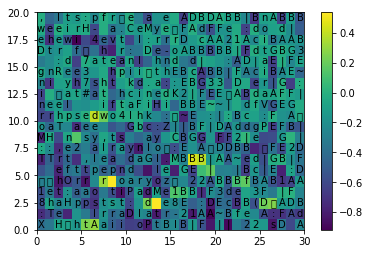

In [8]:
hidden_unit = 64
for lyric in vali_data:
    if len(lyric)>601:
        lyric = lyric[0:601]
        break
batch_in,batch_t = lineToTensor(lyric)
lstm.hidden = lstm.init_hidden()
_,activations = lstm(batch_in)
activations = activations.cpu().data.numpy()
unit_activation = activations.T[hidden_unit].reshape([20,30])

heatmap = plt.pcolor(unit_activation)
for y in range(20):
    for x in range(30):
        plt.text(x + 0.5, y + 0.5, '%s' % lyric[20*x+y],
                 horizontalalignment='center',
                 verticalalignment='center',
                 )
plt.colorbar(heatmap)
plt.show()